In [33]:
from src import search

import pandas as pd
import numpy as np
import seaborn as sns
# import statsmodels.api as sm
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# from sklearn.feature_selection import RFE

from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# from sklearn.svm import SVR
# from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [34]:
df_loaded = pd.read_pickle("training_data.pickle") # EDA.ipynb generates this pickle file, I am not including it in my final deliverable
# due to safety reasons

In [35]:
categorical_cols = df_loaded.select_dtypes("category").columns

In [36]:
label_encoder = LabelEncoder()
df_loaded[categorical_cols] = df_loaded[categorical_cols].apply(
    label_encoder.fit_transform
)

In [37]:
y = df_loaded["vote_average"]
X = df_loaded.drop(columns=["vote_average"])

In [38]:
models = {
    "XGBRegressor": XGBRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    #'LassoRegression': linear_model.Lasso(max_iter=100000),
    #'ElasticNet': linear_model.ElasticNet(),
    #'HuberRegressor': linear_model.HuberRegressor()
    #'SVR' : SVR()
}

# params1 = {

#'RandomForestRegressor': { 'n_estimators': [700,600,500,400],'max_depth' :[45,40,35]},
#'LassoRegression': { 'alpha': [1e-06,1e-05,0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1]},
#'ElasticNet': { 'alpha': [0.1, 0.4, 0.7]},
#'HuberRegressor': {'alpha': [1.2,1.35]}
#'SVR' : {
#        'C': [0.1, 1, 100, 1000],
#        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
#    }
# }
random_grid = {
    "RandomForestRegressor": {
        # "bootstrap": [True, False],
        "max_depth": [10, 40, 50, 60, 70, 80, 90, 100, 110, None],
        "max_features": [None, "sqrt"],
        "min_samples_leaf": [1, 2, 4, 8],
        "min_samples_split": [2, 5, 10],
        # "n_estimators": [700, 600, 400],
    },
    "XGBRegressor": {
        # "n_estimators": [1000, 500, 200, 40],
        "learning_rate": [0.1],
        "max_depth": list(range(30, 40, 2)),
        "min_child_weight": list(range(1, 5, 2)),
    },
}

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

random = search.EstimatorSelectionHelper(models, random_grid)
random.fit(
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    Randomized=True,  # should I run a randomized grid search?
    n_iter=5,
)

Running RandomizedSearchCV for XGBRegressor.
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Running RandomizedSearchCV for RandomForestRegressor.
Fitting 4 folds for each of 5 candidates, totalling 20 fits


In [41]:
random.score_summary(sort_by="mean_score")
# n_estimators default=100

XGBRegressor
RandomForestRegressor


,estimator,min_score,mean_score,max_score,std_score,min_child_weight,max_depth,learning_rate,min_samples_split,min_samples_leaf,max_features
4,XGBRegressor,3.362696,3.500175,3.599801,0.09005,1,36,0.1,NaN,NaN,NaN
2,XGBRegressor,3.380345,3.487436,3.531275,0.062039,1,30,0.1,NaN,NaN,NaN
3,XGBRegressor,3.320805,3.382863,3.415937,0.037498,3,32,0.1,NaN,NaN,NaN
1,XGBRegressor,3.314222,3.382182,3.441063,0.050459,3,36,0.1,NaN,NaN,NaN
0,XGBRegressor,3.312295,3.365556,3.415339,0.044562,3,38,0.1,NaN,NaN,NaN
7,RandomForestRegressor,3.1758,3.21752,3.247183,0.026232,NaN,90,NaN,5,1,None
8,RandomForestRegressor,3.114063,3.177497,3.223163,0.039719,NaN,100,NaN,5,2,None
5,RandomForestRegressor,3.086704,3.130177,3.178459,0.035305,NaN,100,NaN,2,8,sqrt
6,RandomForestRegressor,3.065181,3.11233,3.15533,0.035627,NaN,90,NaN,5,2,sqrt
9,RandomForestRegressor,3.065921,3.106214,3.139423,0.028391,NaN,60,NaN,5,2,sqrt


In [45]:
# random.score_summary(sort_by="mean_score").to_csv("grid_search_score.csv", index=False)

Random Forest Regressor Model Training and Evaluation

Cross-validated mean squared error (MSE) evaluation
for a given model, and then applies it to a RandomForestRegressor with specified hyperparameters.
Fit the model to the training data, makes predictions on both training and test sets,
and reports various performance metrics.

In [46]:
def mse_cv(model):
    kf = KFold(5, shuffle=True, random_state=91).get_n_splits(X)
    mse = -cross_val_score(
        model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf
    )
    return mse


best_random = RandomForestRegressor(
    max_depth=90, min_samples_leaf=1, min_samples_split=5
)
rfr_CV_best = mse_cv(best_random)
best_random.fit(X_train, y_train)
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame(
    {
        "algorithm": ["RandomForest Regressor"],
        "CV error": rfr_CV_best.mean(),
        "CV std": rfr_CV_best.std(),
        "training error (MSE)": [mean_squared_error(y_train, y_train_rfr)],
        "test error (MSE)": [mean_squared_error(y_test, y_test_rfr)],
        "training_r2_score": [r2_score(y_train, y_train_rfr)],
        "test_r2_score": [r2_score(y_test, y_test_rfr)],
    }
)
rfr_best_results

,algorithm,CV error,CV std,training error (MSE),test error (MSE),training_r2_score,test_r2_score
0,RandomForest Regressor,3.229278,0.05778,0.678856,3.13767,0.812182,0.088328


The model is quite bad, the test error is extremely high, even picking XGBoost won't change much

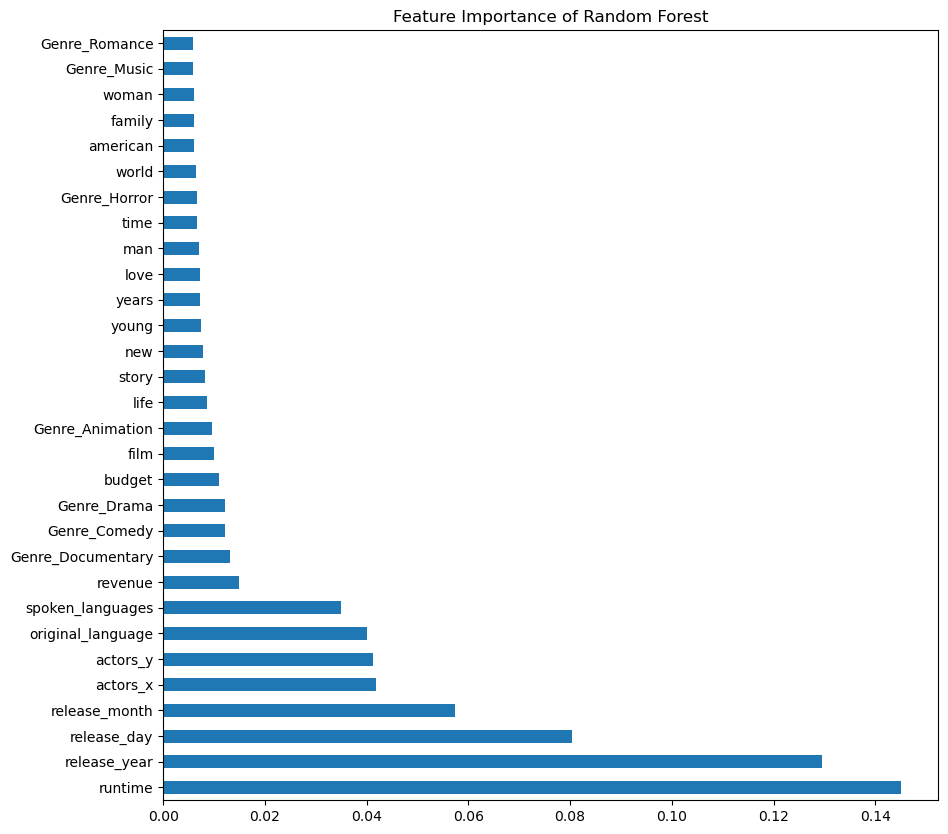

In [47]:
feat_importances = pd.Series(best_random.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(figsize=(10, 10), kind="barh")
plt.title("Feature Importance of Random Forest")
plt.show()

^ I have some duplicate column actors that most likely comes from a merge... 

## Target variable vs Actual Plot

Here I could have used a validation set, but I didn't really have enough time.

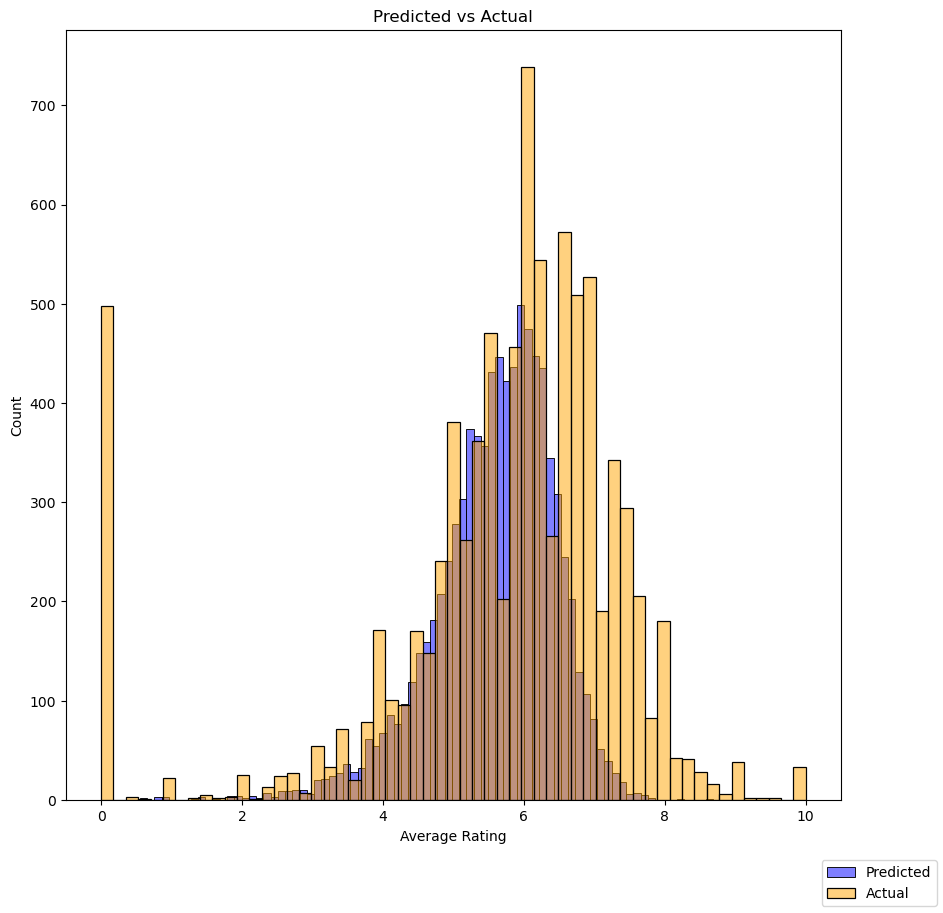

Final Mean Squared Error: 3.1376699980043106


In [51]:
fig = plt.figure(figsize=(10, 10))

# Plot the histograms with visible bars
sns.histplot(y_test_rfr, alpha=0.5, color="blue", label="Predicted")
sns.histplot(y_test, alpha=0.5, color="orange", label="Actual")

# Add legend and set labels
fig.legend(labels=["Predicted", "Actual"], loc="lower right")
plt.title("Predicted vs Actual")
plt.xlabel("Average Rating")

# Show the plot
plt.show()

# Calculate and print the mean squared error
print("Final Mean Squared Error:", mean_squared_error(y_test, y_test_rfr))